In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [4]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

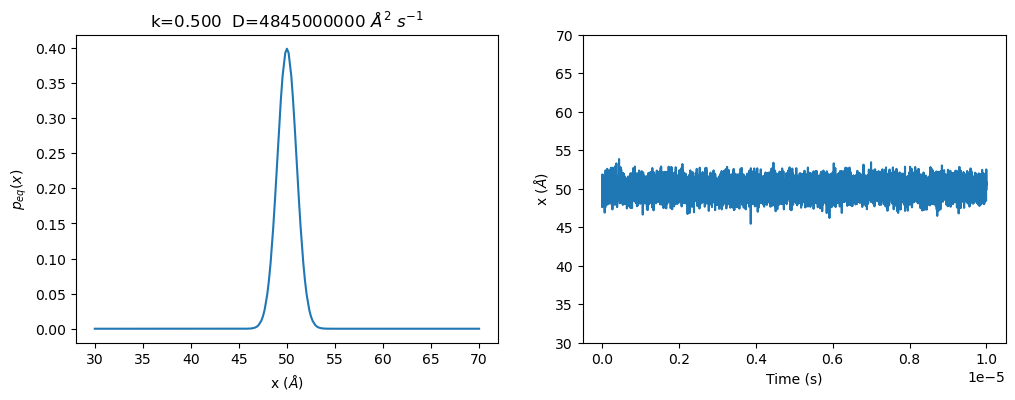

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Gaussian KDE estimation

In [19]:
gaussian(xpoints, mu, sigma) =  (1/(sigma * sqrt(2*pi)))  * exp.((-0.5) * (((xref .- mu) ./ sigma) .^ 2))

gaussian (generic function with 1 method)

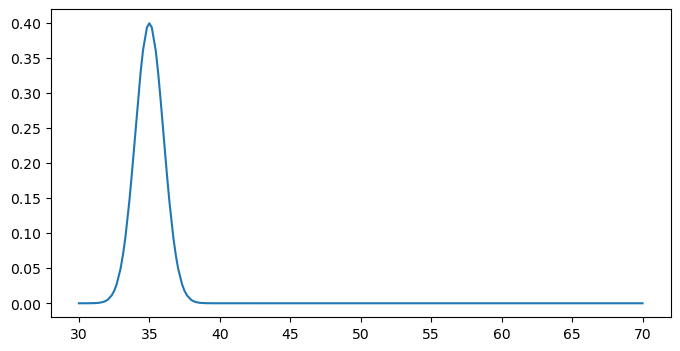

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

y = gaussian(xref, 35, sigma_by_keq)
ax.plot(xref, y)

plt.show()

In [22]:
xref

193×1 Array{Float64,2}:
 30.0
 30.172745751406264
 30.452254248593736
 30.625
 30.797745751406264
 31.077254248593736
 31.25
 31.422745751406264
 31.702254248593736
 31.875
 32.04774575140626
 32.32725424859374
 32.5
  ⋮
 67.67274575140627
 67.95225424859373
 68.125
 68.29774575140627
 68.57725424859373
 68.75
 68.92274575140627
 69.20225424859373
 69.375
 69.54774575140627
 69.82725424859373
 70.0

In [9]:
exp.(xref)

193×1 Array{Float64,2}:
 1.0686474581524463e13
 1.2701557649081922e13
 1.6797551515542592e13
 1.9964962936135277e13
 2.3729633730989625e13
 3.1381957713671945e13
 3.729946129571888e13
 4.433279228926867e13
 5.862921563487656e13
 6.968456778012645e13
 8.28245599761083e13
 1.0953379509728058e14
 1.3018791205063294e14
 ⋮
 2.4541440743733466e29
 3.245555596783774e29
 3.857550139792598e29
 4.584944745904248e29
 6.0634961233128096e29
 7.206852454259625e29
 8.56580448658572e29
 1.1328102120285109e30
 1.3464172963481035e30
 1.6003029604218564e30
 2.116368099160204e30
 2.515438670919167e30